In [3]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import optax

import equinox as eqx

## Example: RNN

In [ ]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jnp.ndarray

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = lax.scan(f, hidden, input)
        # sigmoid because we're performing binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)

In [ ]:
def main(
    dataset_size=10000,
    batch_size=32,
    learning_rate=3e-3,
    steps=200,
    hidden_size=16,
    depth=1,
    seed=5678,
):
    data_key, loader_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 3)
    xs, ys = get_data(dataset_size, key=data_key)
    iter_data = dataloader((xs, ys), batch_size, key=loader_key)

    model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        # Trains with respect to binary cross-entropy
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        print(f"step={step}, loss={loss}")

    pred_ys = jax.vmap(model)(xs)
    num_correct = jnp.sum((pred_ys > 0.5) == ys)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")

## NN

In [4]:
import equinox as eqx
import jax

class MyModule(eqx.Module):
    layers: list
    bias: jax.numpy.ndarray

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        self.layers = [eqx.nn.Linear(1, 8, key=key1),
                        eqx.nn.Linear(8, 8, key=key2),
                        eqx.nn.Linear(8, 8, key=key2),
                        eqx.nn.Linear(8, 1, key=key3)]
        self.bias = jax.numpy.ones(1)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        return self.layers[-1](x) + self.bias

@jax.jit
@jax.grad
def loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2)



In [5]:
def f(x):
    return x**2

x_key, y_key, model_key = jax.random.split(jax.random.PRNGKey(0), 3)
x_train = jrandom.normal(x_key, (10,1))
y_train = f(x_train)
x_test = jnp.linspace(-5, 5, 20).reshape((20,1))
y_test = f(x_test)

model = MyModule(model_key)
learning_rate = 1e-2

for it in range(100):
    x_train = jrandom.normal(x_key, (10,1))
    y_train = f(x_train)
    grads = loss(model, x_train, y_train)
    model = jax.tree_util.tree_map(lambda m, g: m - learning_rate * g, model, grads)

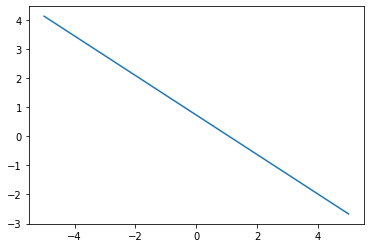

In [6]:
X = np.zeros(20)
for it, x in enumerate(x_test):
    X[it] = model(x)

fig, ax = plt.subplots()
ax.plot(x_test, X)